In [36]:
import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
import ast
import matplotlib.pyplot as plt
import scipy.signal as signal
from wfdb import processing
from scipy.fftpack import fft, ifft 

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    meta_data = data[0][1]
    return data, meta_data


In [3]:
sampling_rate=100
path='/'

Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [4]:
X, meta_data = load_raw_data(Y, sampling_rate, path)

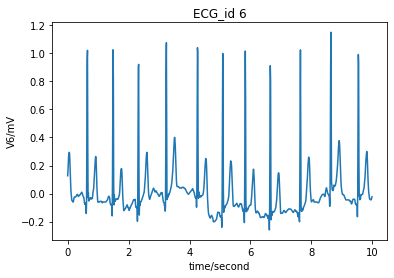

None

In [27]:
record = wfdb.rdrecord(Y.filename_lr.iloc[10], channels = [11])
display(wfdb.plot_wfdb(record=record, title=f'ECG_id {Y.index[5]}'))

In [5]:
print(X.shape)
print(X[0].T.shape)

(21799, 1000, 12)
(12, 1000)


(0.0, 1000.0)

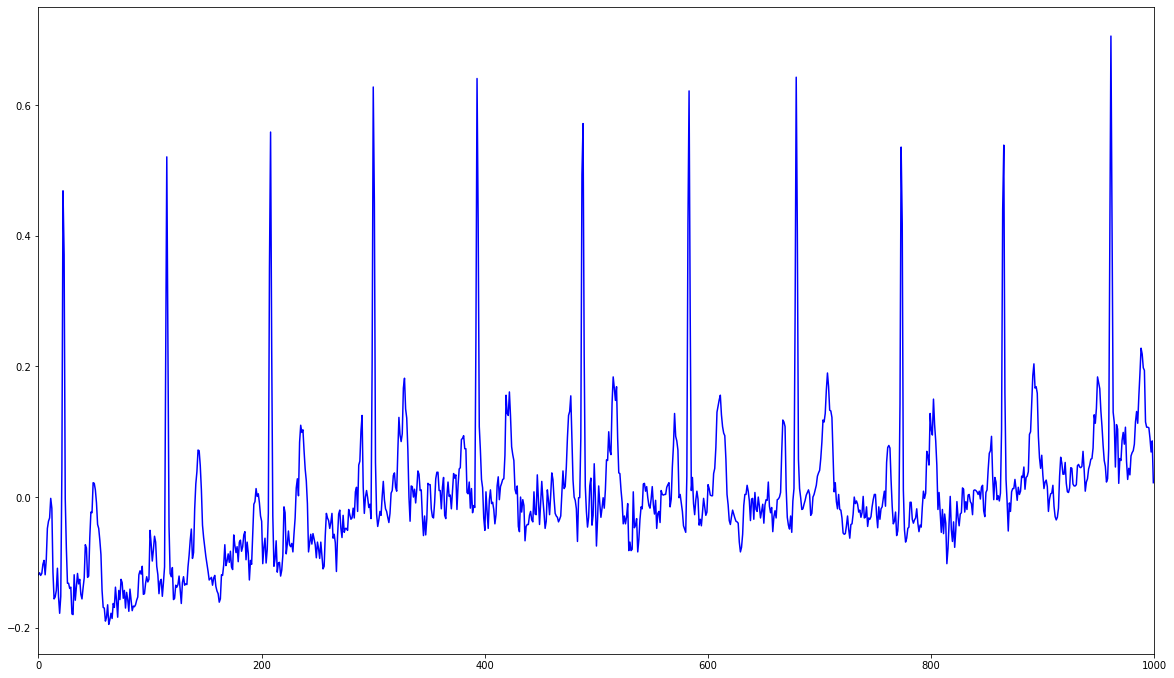

In [7]:
fig = plt.figure(figsize=(20, 50))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot((X[0].T)[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)

PRE-PROCESSING STEP

Frequency domain

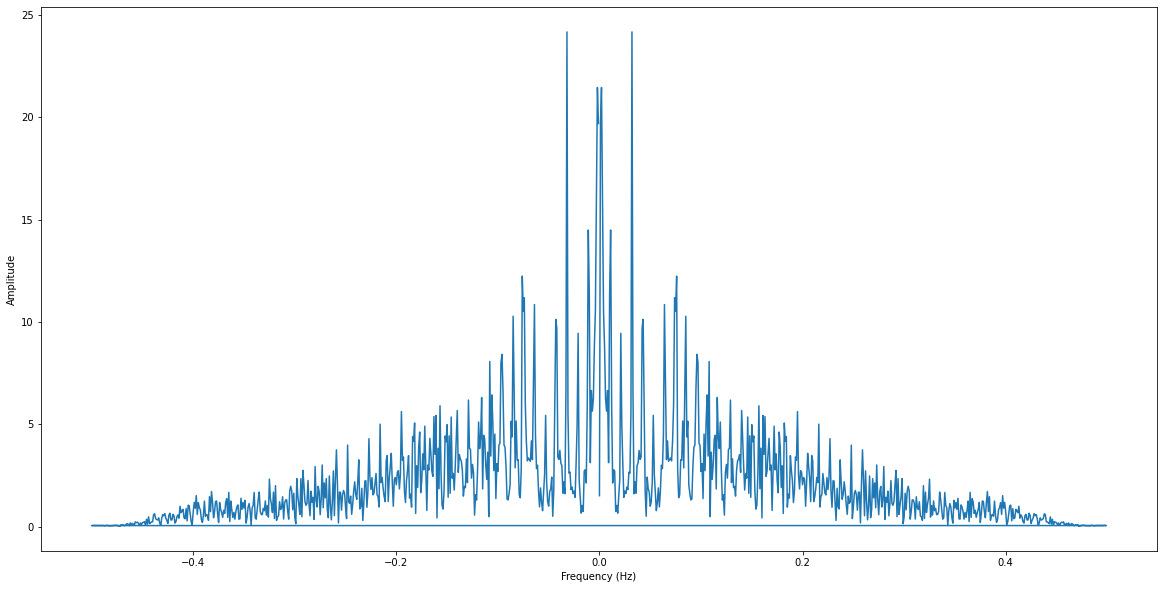

In [21]:
import numpy as np
import matplotlib.pyplot as plt

ecg_spectrum = np.fft.fft(X[0].T[0][:])
freq = np.fft.fftfreq(X[0].T.shape[1])

# Plot frequency spectrum
plt.figure(figsize=(20,10))
plt.plot(freq, np.abs(ecg_spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()


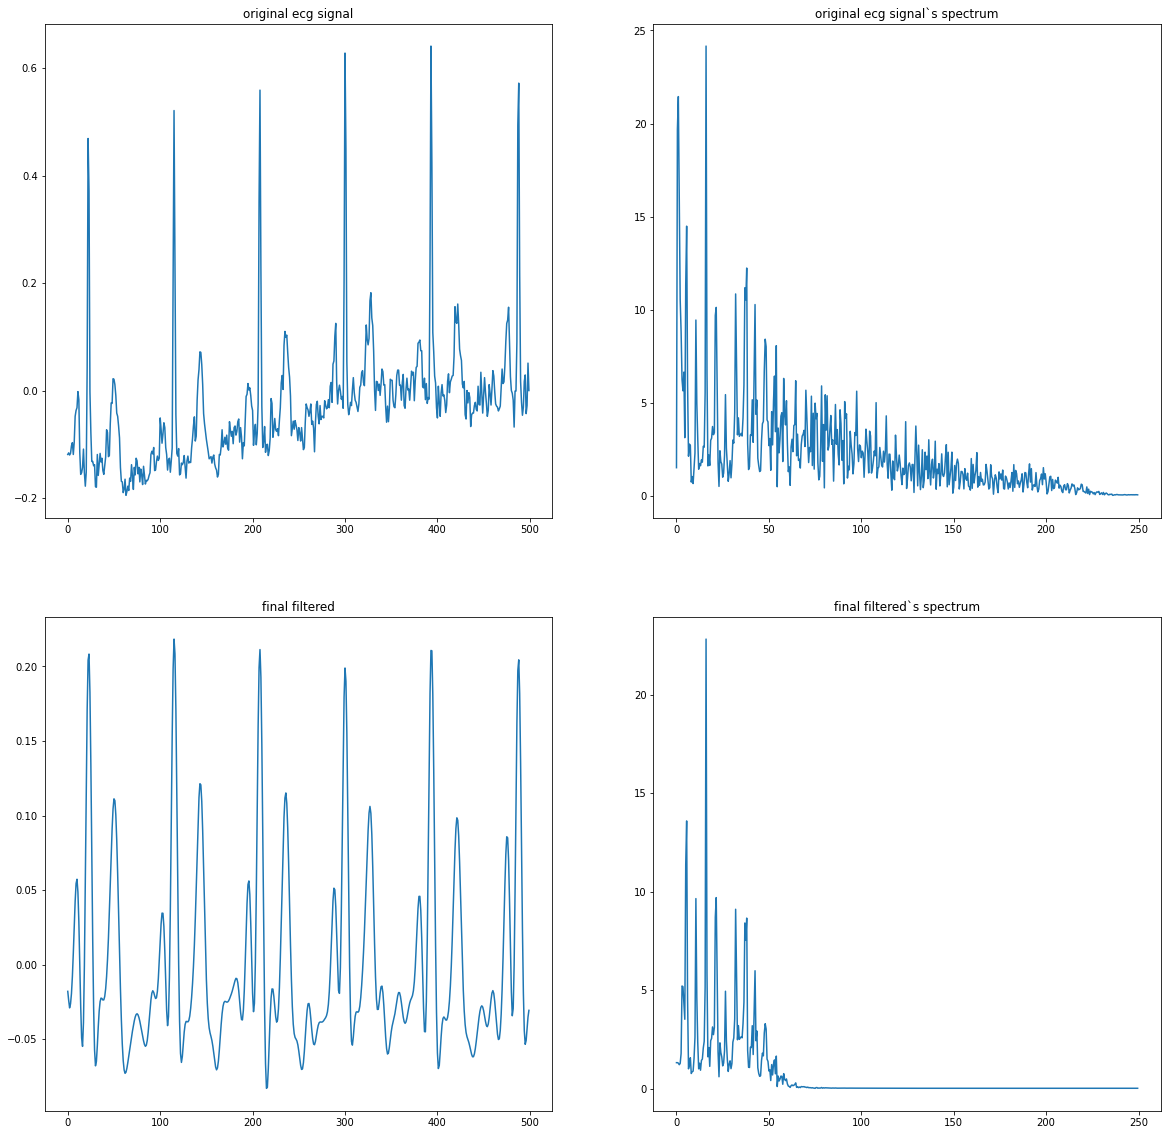

In [39]:
def ecg_fft_ana(ecg_original, sampling_rate):
    fs = 500
    ts = 1.0/fs
    t = np.arange(0, 1, ts)
    n = len(ecg_original)
    k = np.arange(n)
    t = n/fs
    frq = k/t
    frq = frq[range(int(n/2))]
    fft_ecg = np.abs(fft(ecg_original))[range(int(n/2))]
    return frq, fft_ecg



def show_spec_dif(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    frq, fft_ecg = ecg_fft_ana(ecg_original, sampling_rate)
    frq_filtered, fft_ecg_filtered = ecg_fft_ana(ecg_filtered, sampling_rate)
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.plot(ecg_original[:500])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(frq,fft_ecg)
    plt.title(title1 + '`s spectrum')
    plt.subplot(223)
    plt.plot(ecg_filtered[:500])
    plt.title(title2)
    plt.subplot(224)
    plt.plot(frq_filtered, fft_ecg_filtered)
    plt.title(title2 + '`s spectrum')
    plt.show()

show_spec_dif(X[0].T[0][:], MovingAvarage_filtered[0][0], 'original ecg signal', 'final filtered')

baseline wander removal

In [9]:
import scipy.signal as signal
filtered_data = np.zeros((21799, 12, 1000))

for sig in range(X.shape[0]):
    for lead in range(X.shape[2]):
        

        nyquist_freq = 0.5 * 100
        cutoff_freq = 0.5 
        filter_order = 4

        # Design a Butterworth highpass filter
        b, a = signal.butter(filter_order, cutoff_freq / nyquist_freq, btype='highpass')

        # Apply the filter to the ECG signal
        filtered_data[sig][lead] = signal.filtfilt(b, a, X[sig].T[lead][:])


In [10]:
filtered_data.shape
type(filtered_data)

numpy.ndarray

Text(0.5, 1.0, 'baseline filtered ECG')

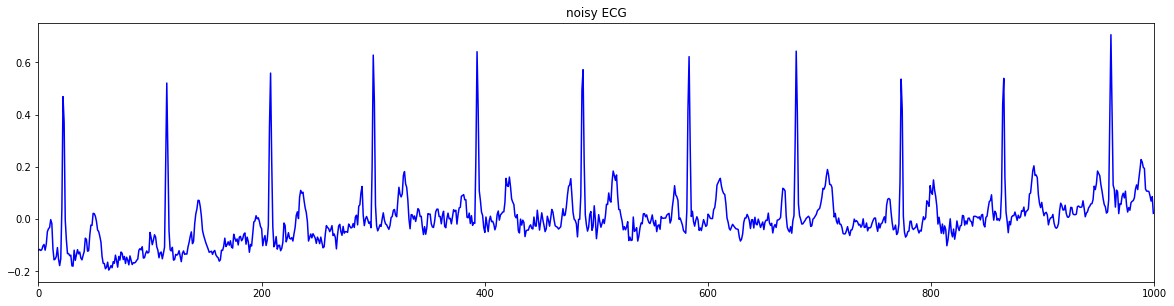

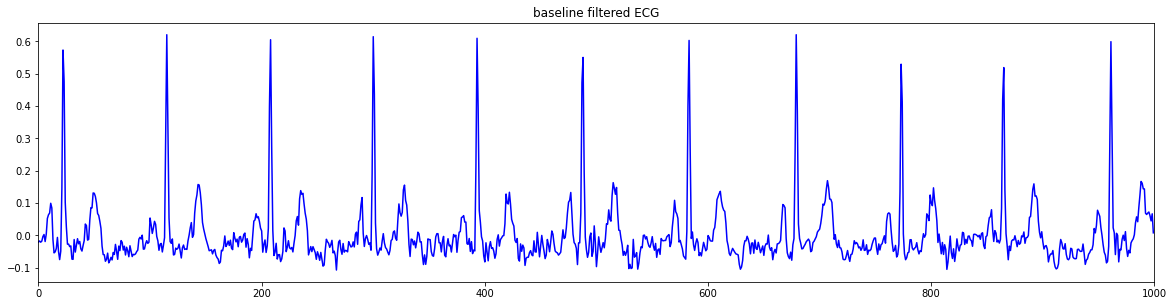

In [11]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot((X[0].T)[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('noisy ECG')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(filtered_data[0][0], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('baseline filtered ECG')

In [12]:
# np.save('highpass_filtered.npy', filtered_data)

In [11]:
loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')

In [12]:
loaded_highpassedfiltered_signal.shape

(21799, 12, 1000)

In [ ]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(X[0].T[11][:], color = 'blue')
arr_signal.set_xlim(0, 1000)

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(filtered_data[0][11], color = 'blue')
arr_signal.set_xlim(0, 1000)

band pass filter

In [16]:
filtered_data_newversion = np.zeros((21799, 12, 1000))

for sig in range(X.shape[0]):
    for lead in range(X.shape[2]):

        lowcut = 0.5  
        highcut = 100 
        order = 4  
        nyquist_freq = 0.5 * 1000
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = signal.butter(order, [low, high], btype='band')

        filtered_data_newversion[sig][lead] = signal.filtfilt(b, a, X[sig].T[lead][:])

In [19]:
import scipy.signal as signal
Highpassesfiltered_data_version2 = np.zeros((21799, 12, 1000))

for sig in range(filtered_data_newversion.shape[0]):
    for lead in range(filtered_data_newversion.shape[1]):
        
        nyquist_freq = 0.5 * 100
        cutoff_freq = 0.5 
        filter_order = 4

        # Design a Butterworth highpass filter
        b, a = signal.butter(filter_order, cutoff_freq / nyquist_freq, btype='highpass')

        # Apply the filter to the ECG signal
        Highpassesfiltered_data_version2[sig][lead] = signal.filtfilt(b, a, filtered_data_newversion[sig][lead][:])


Moving Average Filter

In [32]:
MovingAvarage_filtered = np.zeros((21799, 12, 1000))
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

for sig in range(Highpassesfiltered_data_version2.shape[0]):
    for lead in range(Highpassesfiltered_data_version2.shape[1]):
        MovingAvarage_filtered[sig][lead] = np_move_avg(Highpassesfiltered_data_version2[sig][lead][:], 5)


Text(0.5, 1.0, 'mving average filtered signal')

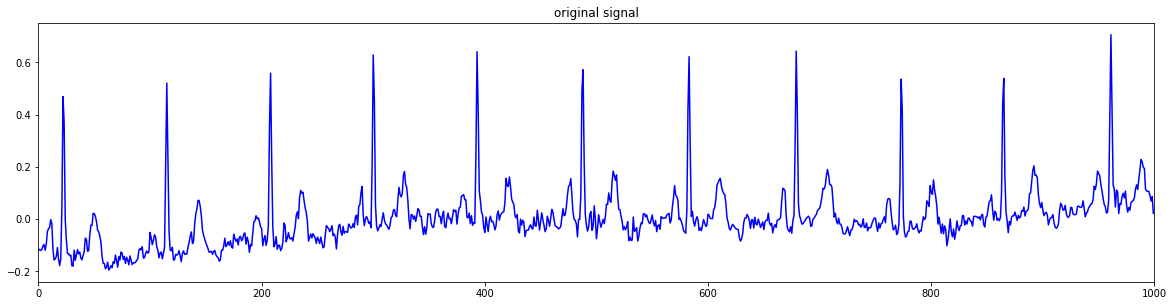

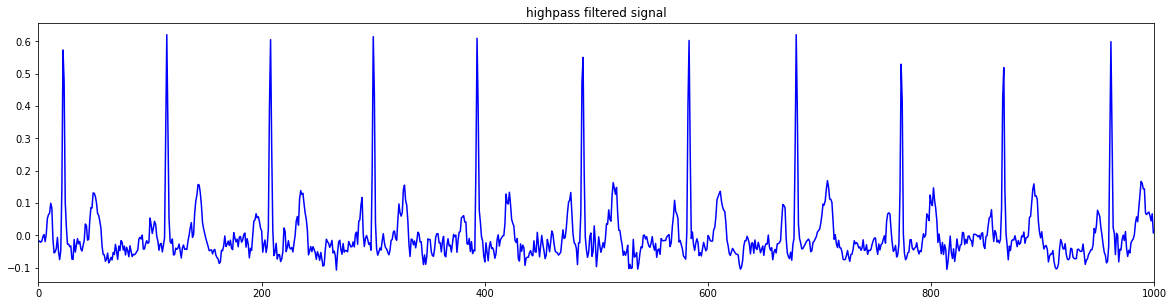

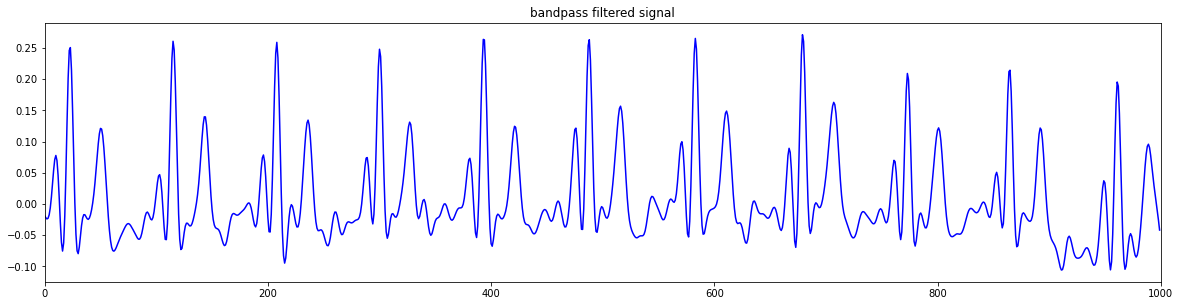

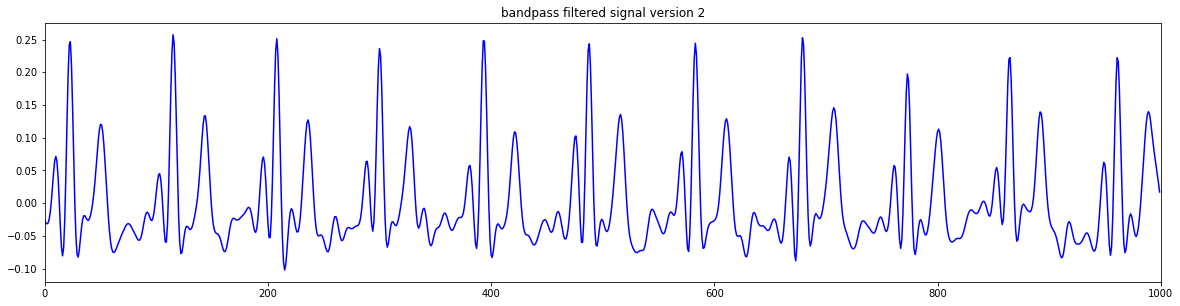

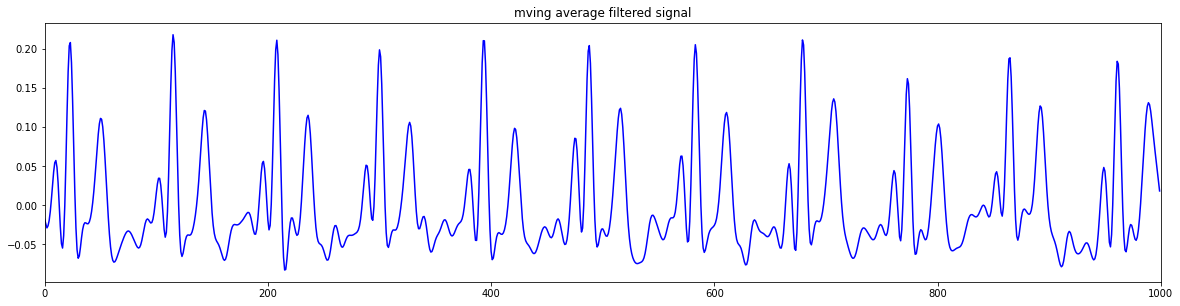

In [33]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(X[0].T[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('original signal')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(loaded_highpassedfiltered_signal[0][0], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('highpass filtered signal')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(filtered_data_newversion[0][0], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('bandpass filtered signal')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(Highpassesfiltered_data_version2[0][0], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('bandpass filtered signal version 2')

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)
arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot(MovingAvarage_filtered[0][0], color = 'blue')
arr_signal.set_xlim(0, 1000)
plt.title('mving average filtered signal')

FEATURE EXTRACTION STEP

R-R interval

In [24]:
# Extract R-peak locations using a peak detection algorithm
r_peaks, _ = wfdb.processing.gqrs_detect(X[0].T[0][:])

# Convert R-peak locations to time stamps
r_times = wfdb.rpeak2time(r_peaks, 100)

# Compute R-R intervals
rr_intervals = np.diff(r_times)

print(rr_intervals)

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

TRAIN 

In [15]:
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
# agg_df.head()

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y.diagnostic_superclass.to_csv('diagnostic_superclass', index=None)

In [16]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass